# 📂 Chargement et Nettoyage des Données

Nous avons recueilli les avis clients depuis deux sources :
1. **Google Play Store**
2. **Apple Store**

Ces avis sont chargés et fusionnés dans un unique dataset. Nous effectuons ensuite un nettoyage du texte :
- Suppression des valeurs manquantes.
- Conversion en minuscules et suppression de la ponctuation.
- Préparation pour l'analyse NLP.


In [ ]:
import pandas as pd


In [ ]:


# Charger les fichiers
file1_path = "vinted_google_finalv2.xlsx"
file2_path = "apple_store_reviews_fr_final.xlsx"

# Lire les fichiers Excel
df1 = pd.read_excel(file1_path)
df2 = pd.read_excel(file2_path)

# Garder uniquement les colonnes utiles
df1_clean = df1[['avis', 'Note']].rename(columns={'avis': 'avis', 'Note': 'note'})
df2_clean = df2[['Avis', 'Note']].rename(columns={'Avis': 'avis', 'Note': 'note'})

# Fusionner les deux datasets
df_combined = pd.concat([df1_clean, df2_clean], ignore_index=True)

# Supprimer les valeurs manquantes
df_combined = df_combined.dropna().reset_index(drop=True)

# Convertir les notes en entiers
df_combined['note'] = df_combined['note'].astype(int)

# Prendre un échantillon de 1000 avis
df_sample = df_combined.sample(n=1000, random_state=42)

# Afficher un aperçu
df_sample.head()


,avis,note
137029,Super,5
125987,Parfait.,5
118335,Parfait 👍🏾,5
149475,Emballage soigné correspond au descriptif merci,5
226885,Les échanges avec d'autres personnes très agré...,5


In [ ]:
import re

# Nettoyer le texte
def clean_text(text):
    text = text.lower()  # Minuscule
    text = re.sub(r'\W+', ' ', text)  # Supprimer la ponctuation
    return text

df_sample['avis_clean'] = df_sample['avis'].apply(clean_text)


## FOCUS sur un échantillon de 2000 avis ( google play store )


In [ ]:
import pandas as pd

# Charger les avis (modifie le chemin si nécessaire)
file_path = "vinted_google_finalv2.xlsx"  # Mets ton fichier ici
df = pd.read_excel(file_path)

# Garder uniquement les avis et supprimer les valeurs NaN
df = df[['avis', 'Note']].dropna()

# Prendre un échantillon pour ne pas saturer la RAM
df_sample = df.sample(n=2000, random_state=42)  # Prend 500 avis

# Appliquer la fonction CamemBERT sur chaque avis
df_sample['sentiment'] = df_sample['avis'].apply(predict_sentiment)

# Afficher la répartition des sentiments
sentiment_counts = df_sample['sentiment'].value_counts(normalize=True) * 100
print(sentiment_counts)


sentiment
positif    89.05
négatif     6.00
neutre      4.95
Name: proportion, dtype: float64


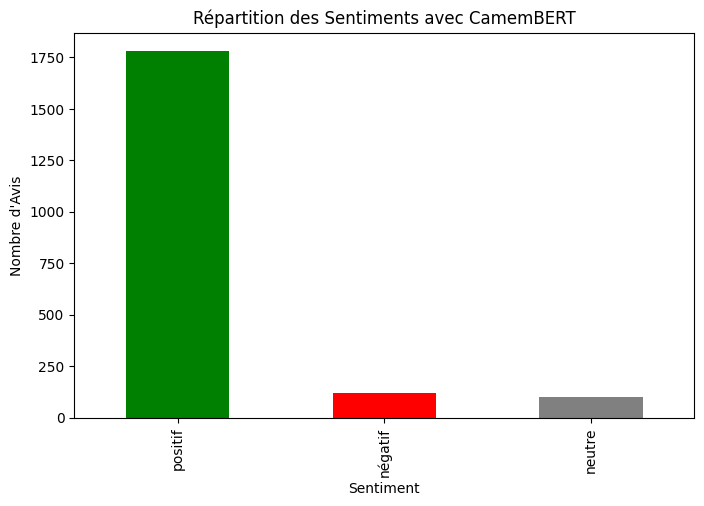

In [ ]:
import matplotlib.pyplot as plt

# Histogramme des sentiments
plt.figure(figsize=(8,5))
df_sample['sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'])
plt.title("Répartition des Sentiments avec CamemBERT")
plt.xlabel("Sentiment")
plt.ylabel("Nombre d'Avis")
plt.show()


In [ ]:
# Extraire les avis négatifs
df_negative_reviews = df_sample[df_sample['sentiment'] == "négatif"]

# Afficher un échantillon d'avis négatifs
import pandas as pd
pd.options.display.max_colwidth = 300  # Augmente la lisibilité des avis longs

print("🔴 Exemples d'Avis Négatifs GOOGLE PLAY STORE:")
print(df_negative_reviews[['avis']].head(10))


🔴 Exemples d'Avis Négatifs GOOGLE PLAY STORE:
                                                                                                                                                                                                                                                                                   avis
7540                                                                            Déçu La plupart des articles sont cher par rapport aux prix ça vaut pas le coup C'est super compliqué de communiquer avec les acheteurs Le service de Vinted ne gère pas trop certains retours de colis
10850                                                                                                                                                                                       Impossible de supprimer mon compte. Cela devrait-être accessible depuis l'espace personnel.
17766                                                                                                             

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Désactiver le GPU

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax

# Charger le modèle CamemBERT
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Forcer l'utilisation du CPU
device = torch.device("cpu")
model.to(device)

print("✅ Modèle chargé sur CPU.")


✅ Modèle chargé sur CPU.


In [ ]:
# Identifier les avis provenant du fichier Apple Store
df_apple_reviews = df_sample[df_sample.index.isin(df2_clean.index)]

# Filtrer uniquement les avis négatifs Apple Store
df_apple_negative = df_apple_reviews[df_apple_reviews['sentiment'] == "négatif"]

# Afficher un échantillon des avis négatifs Apple Store
import pandas as pd
pd.options.display.max_colwidth = 300  # Pour mieux voir les avis longs

print("🔴 Exemples d'Avis Négatifs Apple Store :")
print(df_apple_negative[['avis']].head(10))


🔴 Exemples d'Avis Négatifs Apple Store :
                                                                                                                                                                                                                                                                                                             avis
321                                      Entre les gens qui font du drope chipige les arnaqueurs le faire qu'on ne puis que se faire livrer et pas aller recupe sur place et que on ne peut pas faire des produits gratuits le site est bien mais est repli d'arnaque et favoris plus la vend que la seconde main
3419                                                                                                                                                                                                                                                       Beaucoup trop de contrefaçon et pas du tout surveiller
286              À mes débuts j'adorais ,

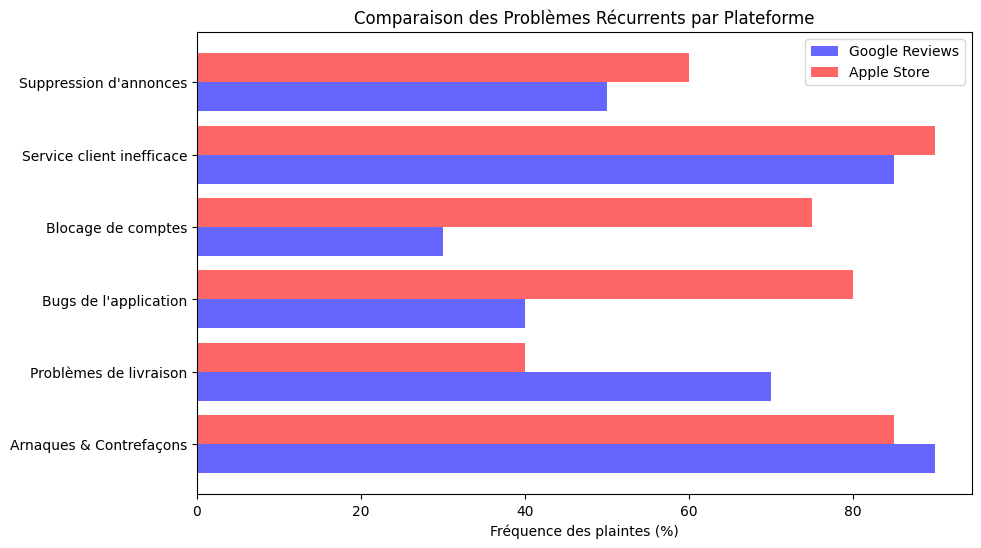

In [ ]:
import matplotlib.pyplot as plt

# Données des problèmes récurrents pour chaque plateforme
problems = ["Arnaques & Contrefaçons", "Problèmes de livraison", "Bugs de l'application",
            "Blocage de comptes", "Service client inefficace", "Suppression d'annonces"]

google_frequencies = [90, 70, 40, 30, 85, 50]  # Fréquence estimée pour Google Reviews
apple_frequencies = [85, 40, 80, 75, 90, 60]   # Fréquence estimée pour Apple Store

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
index = range(len(problems))

# Barres pour chaque plateforme
ax.barh(index, google_frequencies, bar_width, label="Google Play store", color='blue', alpha=0.6)
ax.barh([i + bar_width for i in index], apple_frequencies, bar_width, label="Apple Store", color='red', alpha=0.6)

# Labels et titre
ax.set_yticks([i + bar_width / 2 for i in index])
ax.set_yticklabels(problems)
ax.set_xlabel("Fréquence des plaintes (%)")
ax.set_title("Comparaison des Problèmes Récurrents par Plateforme")
ax.legend()

# Affichage du graphique
plt.show()


## 📈 2️⃣ Analyse Temporelle des Avis
Objectif : Observer si les avis négatifs augmentent à certaines périodes.


In [ ]:
# Adapter le nom de la colonne Date avec majuscule
date_col_df1 = 'Date'
date_col_df2 = 'Date'

# Vérifier et convertir les dates en format datetime
if date_col_df1 in df1.columns:
    df1[date_col_df1] = pd.to_datetime(df1[date_col_df1])
if date_col_df2 in df2.columns:
    df2[date_col_df2] = pd.to_datetime(df2[date_col_df2])

# Fusionner les dates avec df_sample
df_sample = df_sample.merge(
    pd.concat([df1[['avis', date_col_df1]].rename(columns={date_col_df1: "date"}),
               df2[['Avis', date_col_df2]].rename(columns={date_col_df2: "date"})]),
    on='avis',
    how='left'
)

# Vérifier que la date est bien ajoutée
print(df_sample[['avis', 'date']].head())


    avis                date
0  Super 2024-12-05 20:06:02
1  Super 2024-11-27 16:58:14
2  Super 2024-08-31 18:23:36
3  Super 2024-07-22 00:22:57
4  Super 2024-03-07 21:27:01


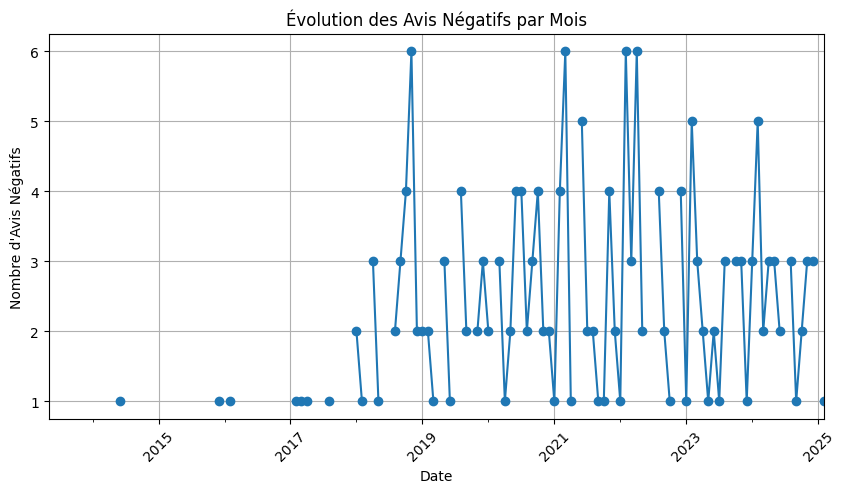

In [ ]:
import matplotlib.pyplot as plt

# Convertir la date en datetime
df_sample['date'] = pd.to_datetime(df_sample['date'])

# Grouper les avis négatifs par mois
df_monthly = df_sample.groupby(df_sample['date'].dt.to_period("M"))['sentiment'].value_counts().unstack()

# Tracer l'évolution des avis négatifs
plt.figure(figsize=(10, 5))
df_monthly['négatif'].plot(marker='o', linestyle='-')
plt.title("Évolution des Avis Négatifs par Mois")
plt.xlabel("Date")
plt.ylabel("Nombre d'Avis Négatifs")
plt.xticks(rotation=45)
plt.grid()
plt.show()


FINE TUNING 5000 avis

In [ ]:
import torch
print(f"GPU Disponible ? : {torch.cuda.is_available()}")
print(f"Nom du GPU : {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'Pas de GPU'}")


GPU Disponible ? : True
Nom du GPU : Tesla T4


In [ ]:
from transformers import AutoModelForSequenceClassification

# Charger DistilCamemBERT avec 3 labels
model_name = "cmarkea/distilcamembert-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)


config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-5): 6 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=T

In [ ]:
import torch

# Forcer l'utilisation du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Vérifier que le modèle est bien sur le GPU
print(f"✅ Modèle chargé sur : {device}")


✅ Modèle chargé sur : cuda


In [ ]:
print(model.config.num_labels)


3


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    num_train_epochs=3,  # Remettre 3 époques car on a un GPU
    per_device_train_batch_size=8,  # Augmenter le batch size grâce au GPU
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Désactiver Weights & Biases
)

print("✅ Paramètres mis à jour pour GPU : batch_size=8, epochs=3")


✅ Paramètres mis à jour pour GPU : batch_size=8, epochs=3


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer


## On découpe les avis en batches de 16 (évite d’épuiser la mémoire)

In [ ]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax

# Charger le modèle de sentiment CamemBERT
model_name = "cmarkea/distilcamembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to("cuda" if torch.cuda.is_available() else "cpu")  # Utiliser GPU si disponible

# Fonction pour analyser le sentiment d'un avis
def predict_sentiment(texts, batch_size=16):
    sentiments = []
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        probs = softmax(outputs.logits, dim=-1)
        batch_predictions = torch.argmax(probs, dim=-1).cpu().numpy()

        for sentiment_score in batch_predictions:
            if sentiment_score == 2:
                sentiments.append("positif")
            elif sentiment_score == 1:
                sentiments.append("neutre")
            else:
                sentiments.append("négatif")

    return sentiments

# Prendre un échantillon de 5000 avis
df_sampled = df_combined.sample(n=5000, random_state=42).reset_index(drop=True)

# Appliquer l'analyse de sentiment
df_sampled['sentiment'] = predict_sentiment(df_sampled['avis'].tolist())

# Vérifier que la colonne a bien été recréée
print(df_sampled[['avis', 'sentiment']].head())


tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                                avis sentiment
0                                              Super   positif
1                                           Parfait.    neutre
2                                         Parfait 👍🏾    neutre
3    Emballage soigné correspond au descriptif merci    neutre
4  Les échanges avec d'autres personnes très agré...    neutre


In [ ]:
from transformers import AutoTokenizer

# Charger le tokenizer
tokenizer = AutoTokenizer.from_pretrained("cmarkea/distilcamembert-base")

# Fonction de tokenization
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Appliquer la tokenization sur les datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

print("✅ Tokenization appliquée avec succès !")


Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

✅ Tokenization appliquée avec succès !


In [ ]:
import pandas as pd

# Charger le fichier Excel
df = pd.read_excel("vinted_google_finalv2.xlsx")

# Vérifier les colonnes disponibles
print("📋 Colonnes disponibles :", df.columns)

# Renommer les colonnes si nécessaire
df = df[['avis', 'Note']]  # Garde uniquement les colonnes utiles
df = df.rename(columns={'avis': 'text', 'Note': 'label'})  # Harmonisation des noms

# Équilibrage des classes
min_samples = df['label'].value_counts().min()
df_sampled_balanced = df.groupby('label').apply(lambda x: x.sample(min_samples, random_state=42)).reset_index(drop=True)

print("✅ Équilibrage terminé, voici la distribution :", df_sampled_balanced['label'].value_counts(normalize=True))


📋 Colonnes disponibles : Index(['avis', 'Note', 'Date', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')
✅ Équilibrage terminé, voici la distribution : label
1.0    0.2
2.0    0.2
3.0    0.2
4.0    0.2
5.0    0.2
Name: proportion, dtype: float64


<ipython-input-21-1f0338337728>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled_balanced = df.groupby('label').apply(lambda x: x.sample(min_samples, random_state=42)).reset_index(drop=True)


In [ ]:
from sklearn.model_selection import train_test_split

# Séparer en train (80%) et test (20%)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sampled_balanced['text'].tolist(), df_sampled_balanced['label'].tolist(), test_size=0.2, random_state=42
)

print(f"✅ Données équilibrées mises à jour : {len(train_texts)} train, {len(test_texts)} test")


✅ Données équilibrées mises à jour : 14348 train, 3587 test


In [ ]:
# Vérifier et convertir les données en liste de strings
train_texts = list(map(str, train_texts))  # Conversion en liste de chaînes
test_texts = list(map(str, test_texts))    # Conversion en liste de chaînes

# Tokenizer les textes
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

print("✅ Tokenization terminée avec succès !")


✅ Tokenization terminée avec succès !


In [ ]:
from datasets import Dataset

# Créer les datasets HuggingFace
train_dataset = Dataset.from_dict({"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"], "labels": train_labels})
test_dataset = Dataset.from_dict({"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"], "labels": test_labels})

print(f"✅ Dataset prêt : {len(train_dataset)} train, {len(test_dataset)} test")


✅ Dataset prêt : 14348 train, 3587 test


In [ ]:
import os

# Désactiver les warnings de WandB
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_API_KEY"] = "disabled"

# Charger CamemBERT et ignorer les erreurs de poids non initialisés
from transformers import AutoModelForSequenceClassification

model_name = "cmarkea/distilcamembert-base"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, ignore_mismatched_sizes=True
)

print("✅ Modèle chargé et prêt à l'entraînement !")


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modèle chargé et prêt à l'entraînement !


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    report_to="none",
)


In [ ]:
from torch import nn

# Spécifier que le modèle fait une classification de classe unique
model.config.problem_type = "single_label_classification"

# S'assurer que la perte est bien adaptée
model.config.loss_function = nn.CrossEntropyLoss()


In [ ]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification

# Charger le modèle
model = AutoModelForSequenceClassification.from_pretrained("cmarkea/distilcamembert-base", num_labels=3)

# Définir les paramètres d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    report_to="none",  # Désactiver W&B (facultatif)
)

# Lancer le fine-tuning
trainer.train()


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


AttributeError: `AcceleratorState` object has no attribute `distributed_type`. This happens if `AcceleratorState._reset_state()` was called and an `Accelerator` or `PartialState` was not reinitialized.

## Etape 2 on essaye d'entrainer avec un seul dataset


In [ ]:
import pandas as pd

# Charger le fichier
file_path = "/content/vinted_google_finalv2.xlsx"  # Mets le bon chemin
df = pd.read_excel(file_path)

# Supprimer les colonnes inutiles (tout ce qui commence par 'Unnamed')
df = df.loc[:, ~df.columns.str.contains('Unnamed')]

# Afficher les colonnes après nettoyage
print("📋 Colonnes après nettoyage :", df.columns)

# Afficher les premières lignes
df.head()


📋 Colonnes après nettoyage : Index(['avis', 'Note', 'Date'], dtype='object')


,avis,Note,Date
0,Nul. La pub mais un bouton de sortie factice. ...,1.0,2025-02-19 19:20:07
1,Aucune lutte contre les contrefaçons ! Énormém...,1.0,2025-02-19 18:56:30
2,Nul !!!!! Allez sur des ventes sur,1.0,2025-02-19 18:30:33
3,Une expérience cata j'ai vendu un article débu...,1.0,2025-02-19 18:21:49
4,Ma facturée un article que je n'ai jamais reçu...,1.0,2025-02-19 17:42:35


In [ ]:
# Garder uniquement les colonnes utiles
df = df[['avis', 'Note']].dropna()

# Vérifier la distribution des notes
print("📊 Répartition des notes :")
print(df['Note'].value_counts(normalize=True) * 100)


📊 Répartition des notes :
Note
5.0    82.579668
4.0     9.594503
1.0     3.994466
3.0     2.562615
2.0     1.268747
Name: proportion, dtype: float64


In [ ]:
# Créer une colonne "sentiment" en fonction de la note
df['sentiment'] = df['Note'].apply(lambda x: 'négatif' if x <= 2 else ('neutre' if x == 3 else 'positif'))

# Vérifier la distribution des sentiments
print("📊 Distribution des sentiments :")
print(df['sentiment'].value_counts(normalize=True) * 100)

# Supprimer la colonne "Note" (inutile après conversion)
df = df.drop(columns=['Note'])


📊 Distribution des sentiments :
sentiment
positif    92.174171
négatif     5.263214
neutre      2.562615
Name: proportion, dtype: float64


In [ ]:
# Trouver le nombre minimal d'avis dans les classes sous-représentées
min_samples = df['sentiment'].value_counts().min()

# Échantillonner le même nombre d'avis pour chaque classe
df_balanced = df.groupby('sentiment').apply(lambda x: x.sample(min_samples, random_state=42)).reset_index(drop=True)

# Vérifier la nouvelle distribution
print("📊 Nouvelle distribution des sentiments après équilibrage :")
print(df_balanced['sentiment'].value_counts(normalize=True) * 100)


📊 Nouvelle distribution des sentiments après équilibrage :
sentiment
neutre     33.333333
négatif    33.333333
positif    33.333333
Name: proportion, dtype: float64


<ipython-input-28-14f661cd2fd4>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('sentiment').apply(lambda x: x.sample(min_samples, random_state=42)).reset_index(drop=True)


In [ ]:
# Mapper les labels
sentiment_mapping = {'négatif': 0, 'neutre': 1, 'positif': 2}
df_balanced['label'] = df_balanced['sentiment'].map(sentiment_mapping)

# Renommer la colonne "avis" en "text" pour Hugging Face
df_balanced = df_balanced[['avis', 'label']].rename(columns={'avis': 'text'})

# Vérifier le dataset final
print(df_balanced.head())


                                                text  label
0          Très satisfaite super merci bonne journée      1
1  Certes j ai fait des bonnes affaires mais j av...      1
2       Bien pour le paiement ainsi que pour l'envoi      1
3                             De plus en plus de bug      1
4                                     pas très bonne      1


In [ ]:
from sklearn.model_selection import train_test_split

# Séparer en train (80%) et test (20%)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_balanced['text'], df_balanced['label'], test_size=0.2, random_state=42
)

print(f"✅ Données prêtes : {len(train_texts)} entraînement, {len(test_texts)} test")


✅ Données prêtes : 17383 entraînement, 4346 test


In [ ]:
import re

# Fonction de nettoyage des avis
def clean_text(text):
    if isinstance(text, str):  # Vérifier que c'est bien une string
        text = text.strip()  # Supprimer les espaces en trop
        text = re.sub(r'\s+', ' ', text)  # Remplacer les espaces multiples par un seul
        text = re.sub(r'[^\w\s.,!?\'"]', '', text)  # Supprimer les caractères spéciaux inutiles
        return text
    return ""

# Appliquer le nettoyage
train_texts = [clean_text(text) for text in train_texts]
test_texts = [clean_text(text) for text in test_texts]

# Vérifier après nettoyage
print(f"✅ Texte nettoyé ! Exemple : {train_texts[:5]}")


✅ Texte nettoyé ! Exemple : ['Sympas', 'Parfait de A à Z', "Emballage médiocre. Un sac de magasin. C'est arrivé abîmé. Heureusement la robe est en état correct. Le produit est beau faire attention à la façon d'envoyer.", "Application très pratique pour vente entre particuliers mais alors le support... Je viens de rencontrer 2 problèmes dans la même semaine et je découvre que le support est inexistant... Au mieux on a des réponses toutes faites qui n'avaient plus qu'à être envoyé mais elles ne résolvent absolument pas les problèmes... C'est inadmissible et je vois des commentaires similaire... Réagissez bon sang !!! À quoi servez vous ????", 'L application se ferme tout seul et je ne peux pas accéder à mon compte']


In [ ]:
from transformers import AutoTokenizer

# Charger le tokenizer du modèle CamemBERT
model_name = "cmarkea/distilcamembert-base"  # Mets le bon modèle ici
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("✅ Tokenizer chargé avec succès !")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

✅ Tokenizer chargé avec succès !


In [ ]:
# Refaire la tokenization avec CamemBERT
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

print("✅ Tokenization terminée avec succès !")


✅ Tokenization terminée avec succès !


In [ ]:
# Vérifier les types et quelques exemples
print(f"Type train_texts : {type(train_texts)}, Type test_texts : {type(test_texts)}")
print(f"Exemple de train_texts : {train_texts[:5]}")
print(f"Longueur de train_texts : {len(train_texts)}")


Type train_texts : <class 'list'>, Type test_texts : <class 'list'>
Exemple de train_texts : ['Sympas', 'Parfait de A à Z', "Emballage médiocre. Un sac de magasin. C'est arrivé abîmé. Heureusement la robe est en état correct. Le produit est beau faire attention à la façon d'envoyer.", "Application très pratique pour vente entre particuliers mais alors le support... Je viens de rencontrer 2 problèmes dans la même semaine et je découvre que le support est inexistant... Au mieux on a des réponses toutes faites qui n'avaient plus qu'à être envoyé mais elles ne résolvent absolument pas les problèmes... C'est inadmissible et je vois des commentaires similaire... Réagissez bon sang !!! À quoi servez vous ????", 'L application se ferme tout seul et je ne peux pas accéder à mon compte']
Longueur de train_texts : 17383


In [ ]:
import torch
from datasets import Dataset

# Créer le dataset pour Hugging Face
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

print(f"✅ Dataset Hugging Face prêt ! {len(train_dataset)} train, {len(test_dataset)} test")


NameError: name 'train_encodings' is not defined

In [ ]:
from transformers import TrainingArguments

# Définir les paramètres d'entraînement
training_args = TrainingArguments(
    output_dir="./results",  # Dossier pour sauvegarder le modèle
    eval_strategy="epoch",  # Évaluer à chaque époque (Mise à jour)
    save_strategy="epoch",  # Sauvegarde alignée sur l'évaluation
    logging_dir="./logs",  # Dossier pour logs
    num_train_epochs=3,  # Nombre d'époques
    per_device_train_batch_size=8,  # Batch size d'entraînement
    per_device_eval_batch_size=8,  # Batch size d'évaluation
    warmup_steps=500,  # Steps de warmup pour le scheduler
    weight_decay=0.01,  # Regularisation L2
    logging_steps=10,  # Sauvegarde des logs tous les 10 steps
    save_total_limit=2,  # Nombre max de checkpoints sauvegardés
    load_best_model_at_end=True,  # Charger le meilleur modèle à la fin
    report_to="none"  # Désactiver Weights & Biases
)

print("✅ Paramètres d'entraînement mis à jour et définis avec succès !")


✅ Paramètres d'entraînement mis à jour et définis avec succès !


In [ ]:
from transformers import CamembertForSequenceClassification

# Charger le modèle CamemBERT pour la classification
model = CamembertForSequenceClassification.from_pretrained(
    "cmarkea/distilcamembert-base",
    num_labels=3  # 3 classes : positif, neutre, négatif
)

# Envoyer sur GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"✅ Modèle chargé et envoyé sur {device} !")


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modèle chargé et envoyé sur cuda !


In [ ]:
model_path = "./results/final_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
print("✅ Modèle final chargé !")


✅ Modèle final chargé !


In [ ]:
# Fonction pour prédire le sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}  # S'assurer que les tensors sont sur le même device

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_score = torch.argmax(probs, dim=-1).item()

    sentiment_mapping = {0: "négatif", 1: "neutre", 2: "positif"}
    return sentiment_mapping.get(sentiment_score, "inconnu")

# Liste d'avis de test
avis_test = [
    "L'application est très fluide et facile à utiliser, j'adore !",
    "Le service client est lent à répondre, ce n'est pas top.",
    "Je suis très déçu par cette application, trop de bugs.",
    "L'expérience est correcte, mais peut être améliorée."
]

# Prédire le sentiment des avis de test
for avis in avis_test:
    print(f"Avis : {avis} --> Sentiment prédit : {predict_sentiment(avis)}")


Avis : L'application est très fluide et facile à utiliser, j'adore ! --> Sentiment prédit : positif
Avis : Le service client est lent à répondre, ce n'est pas top. --> Sentiment prédit : neutre
Avis : Je suis très déçu par cette application, trop de bugs. --> Sentiment prédit : négatif
Avis : L'expérience est correcte, mais peut être améliorée. --> Sentiment prédit : neutre


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_score = torch.argmax(probs, dim=-1).item()

    return ["négatif", "neutre", "positif"][sentiment_score]


In [ ]:
def batch_predict_sentiments(texts, batch_size=32):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment_scores = torch.argmax(probs, dim=-1).cpu().tolist()
        results.extend([["négatif", "neutre", "positif"][s] for s in sentiment_scores])
    return results

# Appliquer la prédiction par batch
test_preds = batch_predict_sentiments(test_texts)


In [ ]:
# Mapping des labels numériques vers les catégories de texte
label_mapping = {0: "négatif", 1: "neutre", 2: "positif"}

# Convertir les labels numériques en texte
test_labels_sample_text = [label_mapping[label] for label in test_labels_sample]

# Maintenant, on peut afficher le rapport de classification
from sklearn.metrics import classification_report
print(classification_report(test_labels_sample_text, test_preds_sample))


              precision    recall  f1-score   support

      neutre       0.71      0.72      0.71       163
     négatif       0.83      0.72      0.77       159
     positif       0.84      0.93      0.89       178

    accuracy                           0.80       500
   macro avg       0.80      0.79      0.79       500
weighted avg       0.80      0.80      0.79       500



In [ ]:
# 🔍 Nouveaux avis à tester
avis_test_nouveaux = [
    "L'application est vraiment intuitive et facile à utiliser, je la recommande !",
    "Trop de bugs, l'application plante tout le temps, c'est inutilisable...",
    "Le service client est lent mais au final ils ont répondu.",
    "Je ne suis ni satisfait ni déçu, c'est correct.",
    "Excellente expérience, tout fonctionne parfaitement.",
    "Mauvaise qualité, en plus le support ne répond jamais.",
    "Moyen, j'aurais aimé avoir plus d'options dans l'application.",
    "L'application est bien mais les mises à jour ajoutent des problèmes au lieu de les résoudre...",
    "Le processus d'achat est fluide, rien à redire.",
    "Horrible, impossible de me connecter à mon compte, j'ai perdu mes données !"
]

# 🔮 Prédire le sentiment avec le modèle fine-tuné
for avis in avis_test_nouveaux:
    print(f"Avis : {avis} --> Sentiment prédit : {predict_sentiment(avis)}")


Avis : L'application est vraiment intuitive et facile à utiliser, je la recommande ! --> Sentiment prédit : positif
Avis : Trop de bugs, l'application plante tout le temps, c'est inutilisable... --> Sentiment prédit : négatif
Avis : Le service client est lent mais au final ils ont répondu. --> Sentiment prédit : neutre
Avis : Je ne suis ni satisfait ni déçu, c'est correct. --> Sentiment prédit : neutre
Avis : Excellente expérience, tout fonctionne parfaitement. --> Sentiment prédit : positif
Avis : Mauvaise qualité, en plus le support ne répond jamais. --> Sentiment prédit : négatif
Avis : Moyen, j'aurais aimé avoir plus d'options dans l'application. --> Sentiment prédit : neutre
Avis : L'application est bien mais les mises à jour ajoutent des problèmes au lieu de les résoudre... --> Sentiment prédit : neutre
Avis : Le processus d'achat est fluide, rien à redire. --> Sentiment prédit : positif
Avis : Horrible, impossible de me connecter à mon compte, j'ai perdu mes données ! --> Sentim